In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [24]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [25]:
input_location = 'KTH-io-aware'
files_prefix = ''
# schedule_names = ['balance-08-ratio-1', 'balance-09-ratio-1', 'balance-10-ratio-1', 'balance-11-ratio-1', 'balance-12-ratio-1', 'balance-14-ratio-1', 'balance-16-ratio-1', 'balance-18-ratio-1']
schedule_names = ['balance-08-largest-1', 'balance-09-largest-1', 'balance-10-largest-1', 'balance-11-largest-1', 'balance-12-largest-1', 'balance-13-largest-1', 'balance-14-largest-1']

In [26]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware/backfill-1_schedule.csv', '../output/KTH-io-aware/balance-08-largest-1_schedule.csv', '../output/KTH-io-aware/balance-08-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-09-largest-1_schedule.csv', '../output/KTH-io-aware/balance-09-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-10-largest-1_schedule.csv', '../output/KTH-io-aware/balance-10-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-11-largest-1_schedule.csv', '../output/KTH-io-aware/balance-11-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-12-largest-1_schedule.csv', '../output/KTH-io-aware/balance-12-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-13-largest-1_schedule.csv', '../output/KTH-io-aware/balance-14-largest-1_schedule.csv', '../output/KTH-io-aware/balance-14-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-16-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-18-ratio-1_schedule.csv', '../output/KTH-io-aware/fcfs_schedule.csv', '../output/KTH-io-awa

In [27]:
def schedule_params(schedule_name):
    _, balance_factor, priority_policy, _ = schedule_name.split('-')
    balance_factor = float(balance_factor) / 10
    return priority_policy, balance_factor

In [28]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        priority_policy, balance_factor = schedule_params(schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        df['priority_policy'] = priority_policy
        df['balance_factor'] = balance_factor
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

 balance-08-largest-1
 balance-09-largest-1
 balance-10-largest-1
 balance-11-largest-1
 balance-12-largest-1
 balance-13-largest-1
 balance-14-largest-1


In [29]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        priority_policy, balance_factor = schedule_params(schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)
        jobsets[schedule_name].df['priority_policy'] = priority_policy
        jobsets[schedule_name].df['balance_factor'] = balance_factor

 balance-08-largest-1
 balance-09-largest-1
 balance-10-largest-1
 balance-11-largest-1
 balance-12-largest-1
 balance-13-largest-1
 balance-14-largest-1


In [30]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [31]:
for schedule in schedule_names:
    print(schedule)
    jobsets[schedule].df = transform_jobset(schedule)

balance-08-largest-1
balance-09-largest-1
balance-10-largest-1
balance-11-largest-1
balance-12-largest-1
balance-13-largest-1
balance-14-largest-1


In [32]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

def create_balance_metric_df():
    dfs = []
    for schedule in schedule_names:
        priority_policy, balance_factor = schedule_params(schedule)
        dfs.append(jobsets[schedule].df[['waiting_time', 'turnaround_time', 'stretch']].assign(priority_policy=priority_policy).assign(balance_factor=balance_factor))
    return pd.concat(dfs)

In [33]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [34]:
metrics.T

schedule,balance-08-largest-1,balance-09-largest-1,balance-10-largest-1,balance-11-largest-1,balance-12-largest-1,balance-13-largest-1,balance-14-largest-1
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0,0,0,0
makespan,2.8804e+07,2.87921e+07,2.88204e+07,2.88037e+07,2.87907e+07,2.88271e+07,2.88046e+07
max_slowdown,1.00024,1.00024,1.00024,1.00024,1.00024,1.00023,1.00023
max_turnaround_time,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,0.0001,0.0001,1e-06,1e-06
mean_slowdown,0.975918,0.975918,0.975918,0.975916,0.975919,0.975918,0.975918
mean_turnaround_time,223.726,223.727,223.735,223.774,223.728,223.764,223.747
mean_waiting_time,0,0,0,0,0,0,0
nb_computing_machines,109,109,109,109,109,109,109


<AxesSubplot:xlabel='balance_factor'>

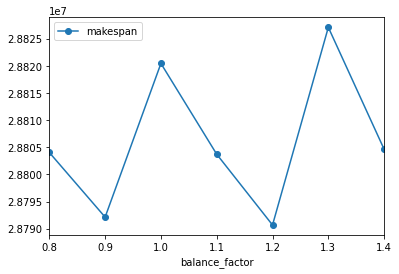

In [35]:
metrics.plot(x='balance_factor', y='makespan', marker='o')

<AxesSubplot:xlabel='balance_factor'>

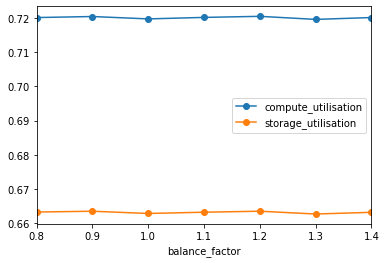

In [36]:
metrics.plot(x='balance_factor', y=['compute_utilisation', 'storage_utilisation'], marker='o')

<AxesSubplot:xlabel='balance_factor'>

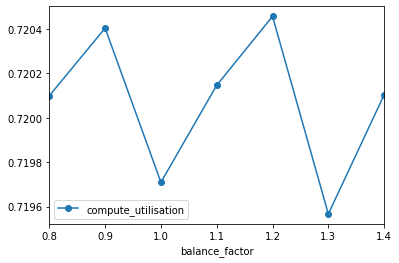

In [37]:
metrics.plot(x='balance_factor', y='compute_utilisation', marker='o')

<AxesSubplot:xlabel='balance_factor'>

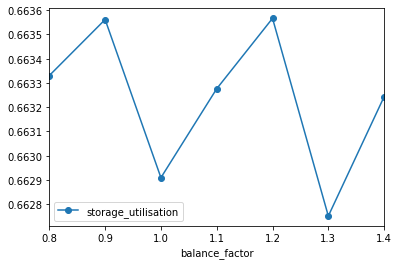

In [38]:
metrics.plot(x='balance_factor', y='storage_utilisation', marker='o')

<AxesSubplot:xlabel='balance_factor', ylabel='compute_utilisation'>

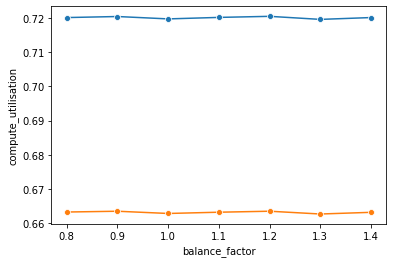

In [39]:
sns.lineplot(data=metrics[['balance_factor', 'compute_utilisation']], x='balance_factor', y='compute_utilisation', marker='o')
sns.lineplot(data=metrics[['balance_factor', 'storage_utilisation']], x='balance_factor', y='storage_utilisation', marker='o')

In [40]:
metrics[['balance_factor', 'compute_utilisation', 'storage_utilisation']]

,balance_factor,compute_utilisation,storage_utilisation
schedule,,,
balance-08-largest-1,0.8,0.720099,0.663331
balance-09-largest-1,0.9,0.720404,0.663562
balance-10-largest-1,1.0,0.719709,0.662909
balance-11-largest-1,1.1,0.720147,0.663276
balance-12-largest-1,1.2,0.720457,0.663567
balance-13-largest-1,1.3,0.719566,0.662751
balance-14-largest-1,1.4,0.720104,0.663243


In [41]:
df = create_balance_metric_df()

In [42]:
df[['balance_factor', 'waiting_time', 'stretch']].groupby('balance_factor').describe()

waiting_time                                                   \
                      count          mean           std  min  25%        50%   
balance_factor                                                                 
0.8                 28453.0  14424.011168  44452.089779  0.0  0.0   0.169746   
0.9                 28453.0  14122.990523  40763.924631  0.0  0.0   0.000000   
1.0                 28453.0  14554.519621  42866.157714  0.0  0.0  13.821833   
1.1                 28453.0  14028.049805  42085.263298  0.0  0.0   5.847458   
1.2                 28453.0  14624.677337  42373.829681  0.0  0.0  50.834948   
1.3                 28453.0  13687.871928  39548.352014  0.0  0.0  10.695741   
1.4                 28453.0  14651.478358  44375.301803  0.0  0.0   6.144295   

                                            stretch                           \
                        75%            max    count        mean          std   
balance_factor                                                                 
0.8             7459.324741  683498.469694  28453.0  155.641284  1200.739359   
0.9             7699.781083  587128.971333  28453.0  189.385800  1685.877827   
1.0             7717.325888  567128.171541  28453.0  187.158905  1785.998219   
1.1             7940.000000  678636.304014  28453.0  178.400861  1385.622668   
1.2             8132.360182  595307.786804  28453.0  217.743814  1699.069270   
1.3             7869.248020  665114.154877  28453.0  191.200542  1534.673255   
1.4             8161.547032  734689.567015  28453.0  202.051985  1691.757956   

                                                             
                min  25%       50%       75%            max  
balance_factor                                               
0.8             1.0  1.0  1.000295  5.775488  104436.184122  
0.9             1.0  1.0  1.000000  5.129212  130891.808851  
1.0             1.0  1.0  1.008795  6.635415  143338.212148  
1.1             1.0  1.0  1.005077  5.951358  126388.257814  
1.2             1.0  1.0  1.024091  7.343495  121445.551673  
1.3             1.0  1.0  1.007710  5.740966   83550.879862  
1.4             1.0  1.0  1.004467  5.897934  105771.523655

<AxesSubplot:xlabel='balance_factor', ylabel='waiting_time'>

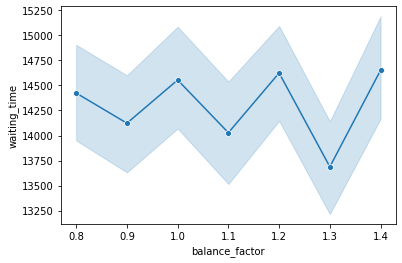

In [43]:
sns.lineplot(data=df, x='balance_factor', y='waiting_time', estimator=np.mean, marker='o')

<AxesSubplot:xlabel='balance_factor', ylabel='stretch'>

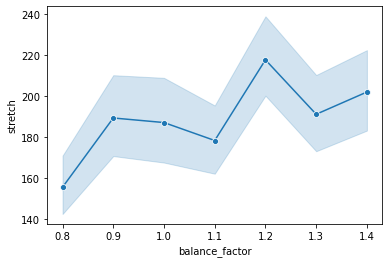

In [44]:
sns.lineplot(data=df, x='balance_factor', y='stretch', estimator=np.mean, marker='o')